# complete example Single world

/home/kreffert/Probabilistic_LTSF/notebooks/experiments


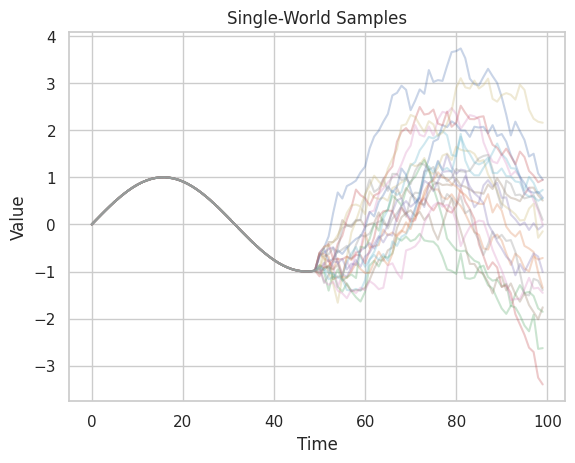

In [1]:
# Cell 1: Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/home/kreffert/Probabilistic_LTSF/notebooks/experiments')
print(os.getcwd())
from experiments import *

sns.set(style="whitegrid")
torch.manual_seed(42)
np.random.seed(42)

def plot_trajectories(samples, title=""):
    for s in samples:
        plt.plot(s, alpha=0.3)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

multi_world = sample_multi_trajectories()
plot_trajectories(multi_world, title="Single-World Samples")

In [2]:
# Cell 6: Prepare Training Data
prefix_len = 50
forecast_horizon = 40

multi_samples = sample_multi_trajectories(n_samples=100)
X = multi_samples[:, :prefix_len]
Y = multi_samples[:, prefix_len:prefix_len + forecast_horizon]

X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

model_dms = GaussianForecastModel(prefix_len, forecast_horizon)
train_dms(model_dms, X_train, Y_train)

  4%|█████▋                                                                                                                                                       | 36/1000 [00:00<00:05, 179.43it/s]

Epoch 0: NLL = 1.6193


 28%|███████████████████████████████████████████▋                                                                                                                | 280/1000 [00:00<00:01, 387.34it/s]

Epoch 200: NLL = 1.1942


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                      | 448/1000 [00:01<00:01, 411.01it/s]

Epoch 400: NLL = 1.1942


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 658/1000 [00:01<00:00, 415.10it/s]

Epoch 600: NLL = 1.1942


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 866/1000 [00:02<00:00, 404.24it/s]

Epoch 800: NLL = 1.1942


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.70it/s]


In [3]:
ims_input_len = 50
X_ims, Y_ims = build_ims_dataset(multi_samples, ims_input_len)

model_ims = IMSLSTM(hidden_size=64)
train_ims(model_ims, X_ims, Y_ims)

/home/kreffert/Probabilistic_LTSF/notebooks/experiments/experiments.py:245: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
  0%|▎                                                                                                                                                               | 1/500 [00:00<04:52,  1.71it/s]

[IMS] Epoch 0 | NLL: 1.6291


 20%|███████████████████████████████▉                                                                                                                              | 101/500 [00:50<03:16,  2.03it/s]

[IMS] Epoch 100 | NLL: 0.0143


 40%|███████████████████████████████████████████████████████████████▌                                                                                              | 201/500 [01:39<02:26,  2.04it/s]

[IMS] Epoch 200 | NLL: -0.1664


 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                               | 301/500 [02:29<01:38,  2.03it/s]

[IMS] Epoch 300 | NLL: -0.1816


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 401/500 [03:18<00:48,  2.05it/s]

[IMS] Epoch 400 | NLL: -0.2010


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:07<00:00,  2.02it/s]


In [4]:
def nll_empirical_gaussian(y_true, sample_trajectories):
    """
    Compute NLL assuming a Gaussian fitted to the empirical samples at each step.

    Args:
        y_true: [forecast_horizon]
        sample_trajectories: [n_samples, forecast_horizon]
    
    Returns:
        nll: scalar (mean over horizon)
    """
    mu = sample_trajectories.mean(axis=0)
    std = sample_trajectories.std(axis=0)
    return nll_gaussian(y_true, mu, std).mean()
    
# Choose train sample
test_idx = 1
x_test = torch.tensor(multi_samples[test_idx, :prefix_len], dtype=torch.float32)
y_true = multi_samples[test_idx, prefix_len:prefix_len + forecast_horizon]

# IMS via LSTM
mu_ims_lstm, sigma_ims_lstm = autoregressive_lstm_forecast(model_ims, x_test, forecast_horizon)

# DMS from earlier
with torch.no_grad():
    mu_dms, sigma_dms = model_dms(x_test.unsqueeze(0))
    mu_dms, sigma_dms = mu_dms[0].numpy(), sigma_dms[0].numpy()

# Extract forecast samples from ground truth for the same prefix
gt_trajectories = multi_samples[:, prefix_len:prefix_len + forecast_horizon]

# Ground truth NLL and Entropy
nll_gt = nll_empirical_gaussian(y_true, gt_trajectories)
entropy_gt = gaussian_entropy(gt_trajectories.std(axis=0)).mean()

# === Print comparison ===
print("\n=== LSTM IMS vs DMS vs Ground Truth ===")
for name, mu, sigma in zip(["DMS", "LSTM IMS"], [mu_dms, mu_ims_lstm], [sigma_dms, sigma_ims_lstm]):
    nll = nll_gaussian(y_true, mu, sigma).mean()
    entropy = gaussian_entropy(sigma).mean()
    print(f"{name}:       NLL = {nll:.3f}, Entropy = {entropy:.3f}")

print(f"Ground Truth: NLL = {nll_gt:.3f}, Entropy = {entropy_gt:.3f}")


=== LSTM IMS vs DMS vs Ground Truth ===
DMS:       NLL = 0.822, Entropy = 1.194
LSTM IMS:       NLL = 9.136, Entropy = -0.209
Ground Truth: NLL = 0.822, Entropy = 1.194


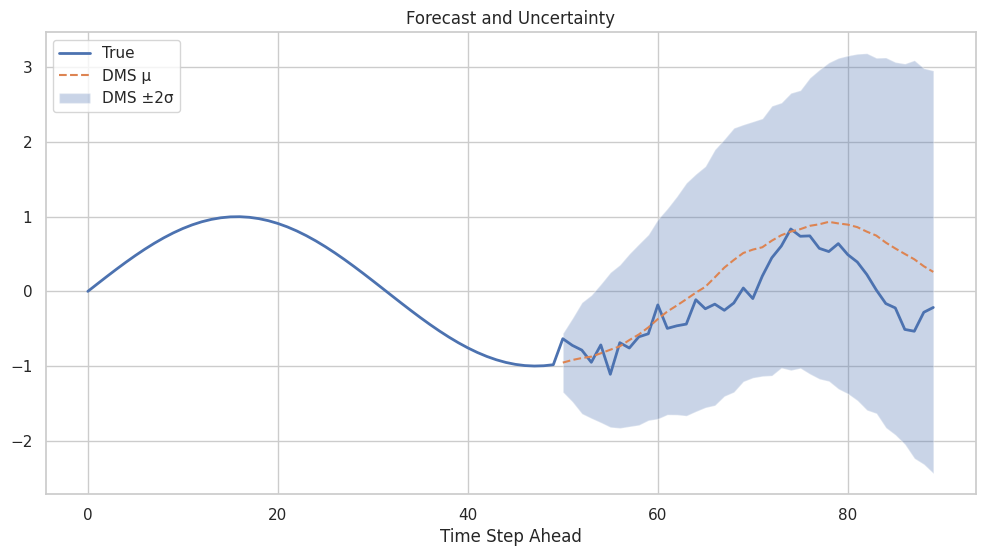

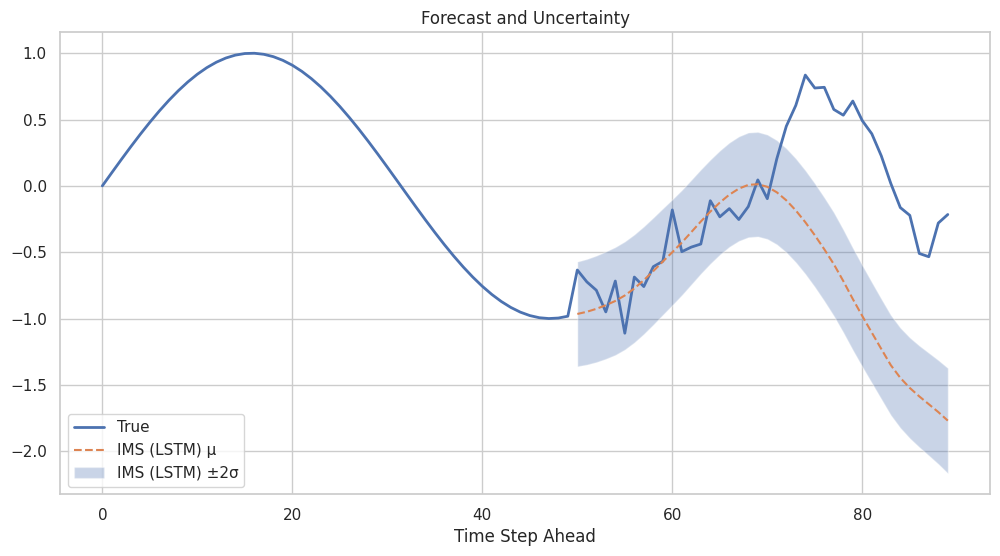

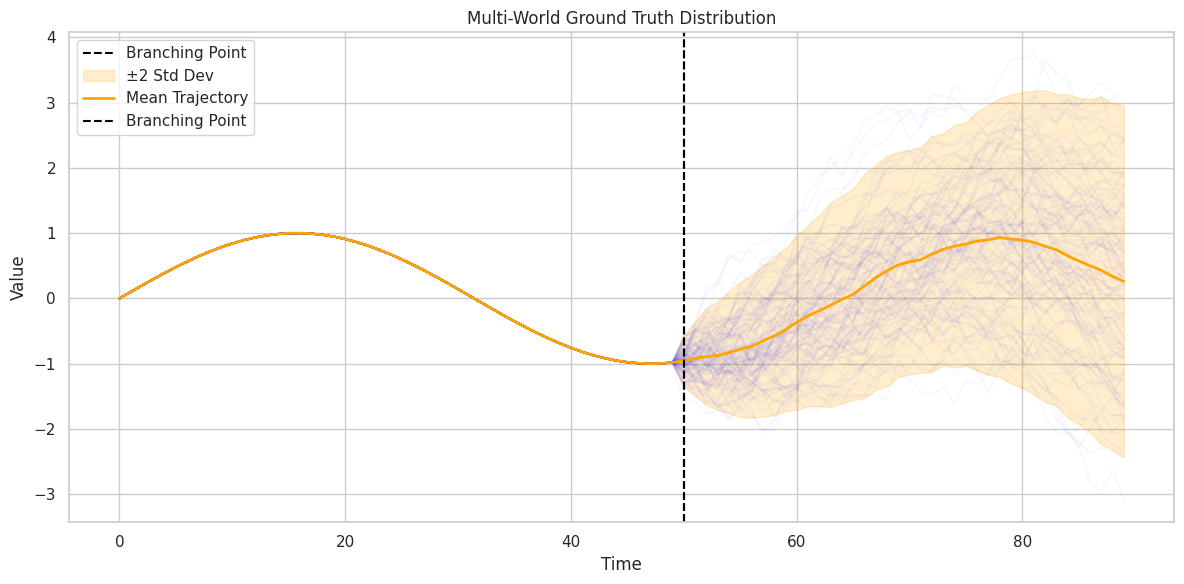

In [5]:
def plot_forecast(x_test, y_true, mu, sigma, label="Model"):
    y = np.concat([x_test.detach().cpu(), y_true])
    t = np.arange(len(y))
    test = t[-len(y_true):]
    plt.figure(figsize=(12, 6))
    plt.plot(t, y, label="True", linewidth=2)
    plt.plot(test, mu, label=f"{label} μ", linestyle="--")
    plt.fill_between(test, mu - 2*sigma, mu + 2*sigma, alpha=0.3, label=f"{label} ±2σ")
    plt.title("Forecast and Uncertainty")
    plt.xlabel("Time Step Ahead")
    plt.legend()
    plt.show()

plot_forecast(x_test, y_true, mu_dms, sigma_dms, label="DMS")
plot_forecast(x_test, y_true, mu_ims_lstm, sigma_ims_lstm, label="IMS (LSTM)")
plot_multi_world_distribution(multi_samples, prefix_len=prefix_len, forecast_horizon=forecast_horizon)

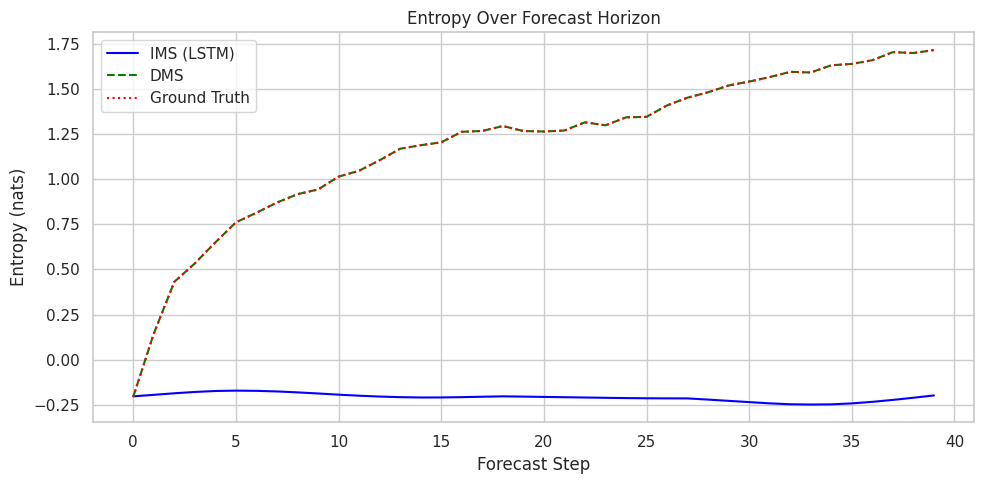

In [6]:
# Define colors and line styles for each model
plot_styles = {
    "IMS (LSTM)": {"color": "blue", "linestyle": "-"},
    "DMS": {"color": "green", "linestyle": "--"},
    "Ground Truth": {"color": "red", "linestyle": ":"}
}

# Compute ground truth entropy from the data-generating process
ground_truth_entropy = estimate_ground_truth_entropy(
    samples=multi_samples,
    prefix_len=prefix_len,
    forecast_horizon=forecast_horizon
)

# Combine model sigmas into a dictionary
entropies_dict = {
    "IMS (LSTM)": sigma_ims_lstm,
    "DMS": sigma_dms,
    "Ground Truth": np.std(multi_samples[:, prefix_len:prefix_len+forecast_horizon], axis=0)
}

# Convert sigmas to entropy values
entropy_plot_data = {
    label: gaussian_entropy(sigmas)
    for label, sigmas in entropies_dict.items()
}

# Plot with styling
plt.figure(figsize=(10, 5))
for label, entropy_vals in entropy_plot_data.items():
    style = plot_styles.get(label, {})
    plt.plot(entropy_vals, label=label, **style)

plt.title("Entropy Over Forecast Horizon")
plt.xlabel("Forecast Step")
plt.ylabel("Entropy (nats)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# complete example multi-world

### Multi-World Entropy Formula

For a given time step $t$ after the branching point:

$$H(X_t) = H_{between} + H_{within}$$

Where:

- $H_{between}$ is the entropy from choosing between worlds
- $H_{within}$ is the expected entropy within each world

More specifically:

$$H_{between} = -\sum_{i=1}^{n_{worlds}} p(w_i) \log p(w_i)$$

Since all worlds have equal probability $p(w_i) = \frac{1}{n_{worlds}}$, this simplifies to:

$$H_{between} = -n_{worlds} \cdot \frac{1}{n_{worlds}} \log \frac{1}{n_{worlds}} = \log(n_{worlds})$$

For the within-world entropy, assuming Gaussian distributions within each world:

$$H_{within} = \sum_{i=1}^{n_{worlds}} p(w_i) \cdot H(X_t|w_i)$$

For a Gaussian with standard deviation $\sigma_i$ in world $i$:

$$H(X_t|w_i) = \frac{1}{2}\log(2\pi e \sigma_i^2)$$

Therefore, the total entropy is:

$$H(X_t) = \log(n_{worlds}) + \frac{1}{n_{worlds}}\sum_{i=1}^{n_{worlds}}\frac{1}{2}\log(2\pi e \sigma_i^2)$$

In [7]:
multi_samples, world_ids = sample_multi_trajectories_with_worlds(
    n_samples=30,
    seq_len=100,
    branching_point=50,
    n_worlds=2
)

In [8]:
# Cell 6: Prepare Training Data
prefix_len = 50
forecast_horizon = 40
X = multi_samples[:, :prefix_len]
Y = multi_samples[:, prefix_len:prefix_len + forecast_horizon]

X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

model_dms = GaussianForecastModel(prefix_len, forecast_horizon)
train_dms(model_dms, X_train, Y_train)

ims_input_len = 50
X_ims, Y_ims = build_ims_dataset(multi_samples, ims_input_len)

model_ims = IMSLSTM(hidden_size=64)
train_ims(model_ims, X_ims, Y_ims)

  8%|█████████████▏                                                                                                                                               | 84/1000 [00:00<00:02, 419.47it/s]

Epoch 0: NLL = 1.1568


 26%|████████████████████████████████████████▍                                                                                                                   | 259/1000 [00:00<00:01, 432.10it/s]

Epoch 200: NLL = 0.1242


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                 | 479/1000 [00:01<00:01, 437.33it/s]

Epoch 400: NLL = 0.1245


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 655/1000 [00:01<00:00, 431.73it/s]

Epoch 600: NLL = 0.1241


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 873/1000 [00:02<00:00, 424.74it/s]

Epoch 800: NLL = 0.1242


  0%|▎                                                                                                                                                               | 1/500 [00:00<01:50,  4.52it/s]

[IMS] Epoch 0 | NLL: 1.1973


 20%|███████████████████████████████▉                                                                                                                              | 101/500 [00:23<01:30,  4.41it/s]

[IMS] Epoch 100 | NLL: -0.0956


 40%|███████████████████████████████████████████████████████████████▌                                                                                              | 201/500 [00:45<01:06,  4.47it/s]

[IMS] Epoch 200 | NLL: -0.2124


 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                               | 301/500 [01:08<00:45,  4.39it/s]

[IMS] Epoch 300 | NLL: -0.2518


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 401/500 [01:31<00:23,  4.21it/s]

[IMS] Epoch 400 | NLL: -0.2724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:54<00:00,  4.38it/s]


/home/kreffert/Probabilistic_LTSF/notebooks/experiments/experiments.py:254: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.log(2 * np.pi * np.e * sigma**2)



=== LSTM IMS vs DMS vs Ground Truth ===
DMS:       NLL = 0.171, Entropy = 0.139
LSTM IMS:       NLL = 7.542, Entropy = -0.381
Ground Truth: NLL = -0.264, Entropy = 0.264


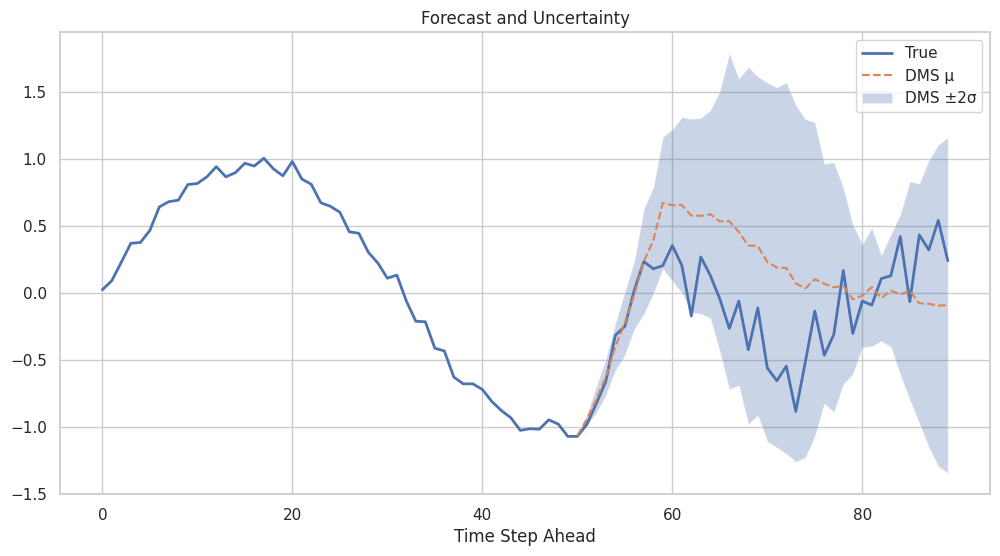

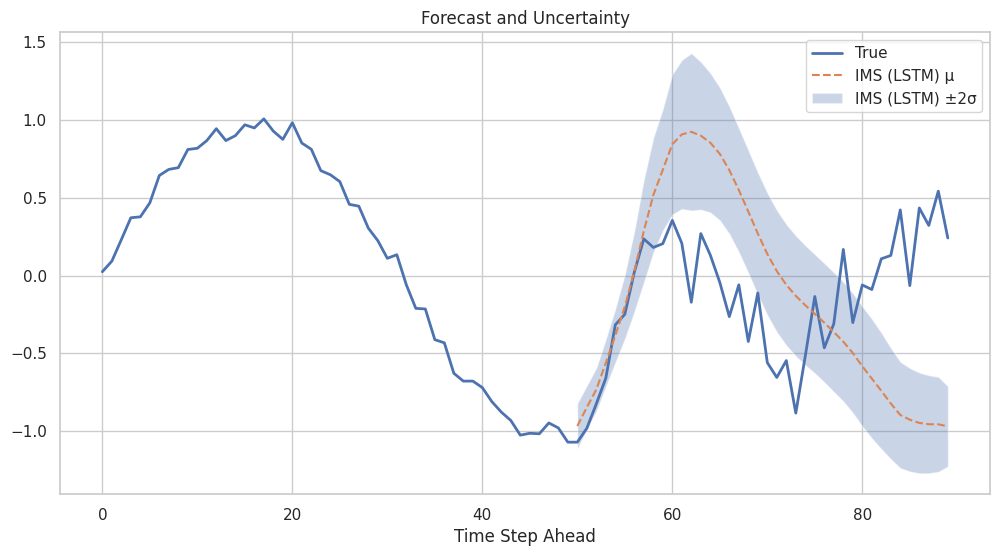

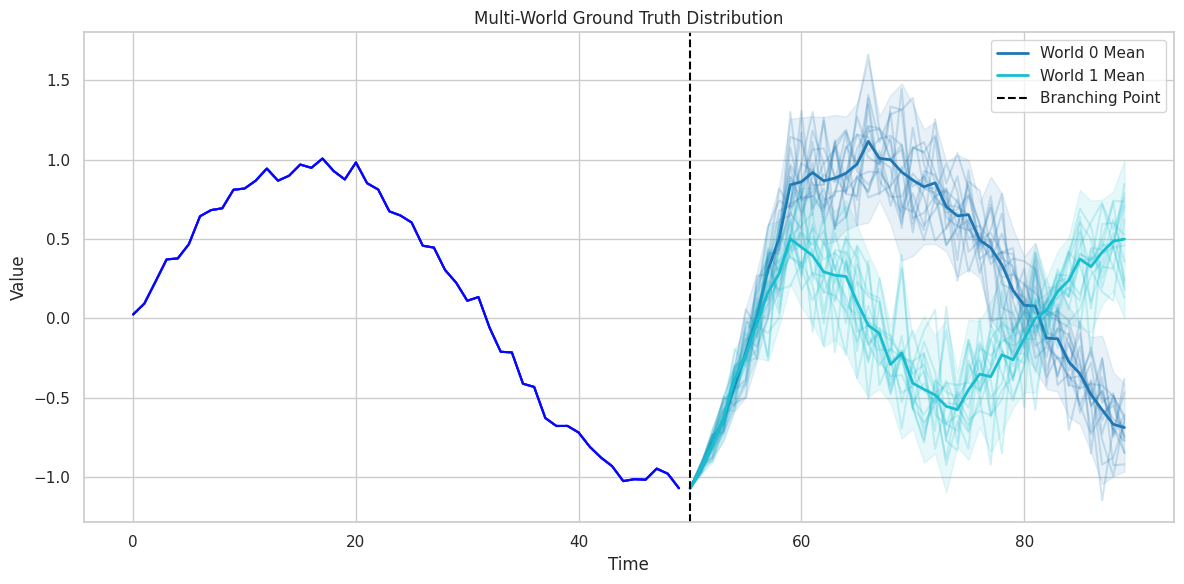

In [9]:
# Choose train sample
test_idx = 29
x_test = torch.tensor(multi_samples[test_idx, :prefix_len], dtype=torch.float32)
y_true = multi_samples[test_idx, prefix_len:prefix_len + forecast_horizon]

# IMS via LSTM
mu_ims_lstm, sigma_ims_lstm = autoregressive_lstm_forecast(model_ims, x_test, forecast_horizon)

# DMS from earlier
with torch.no_grad():
    mu_dms, sigma_dms = model_dms(x_test.unsqueeze(0))
    mu_dms, sigma_dms = mu_dms[0].numpy(), sigma_dms[0].numpy()

entropy_gt = estimate_ground_truth_entropy(multi_samples, world_ids=world_ids, prefix_len=prefix_len, forecast_horizon=forecast_horizon)[1:].mean()
nll_gt = compute_sample_nll(multi_samples[test_idx,:], multi_samples, world_ids, prefix_len=prefix_len, forecast_horizon=forecast_horizon).mean()
# === Print comparison ===
print("\n=== LSTM IMS vs DMS vs Ground Truth ===")
for name, mu, sigma in zip(["DMS", "LSTM IMS"], [mu_dms, mu_ims_lstm], [sigma_dms, sigma_ims_lstm]):
    nll = nll_gaussian(y_true, mu, sigma).mean()
    entropy = gaussian_entropy(sigma).mean()
    print(f"{name}:       NLL = {nll:.3f}, Entropy = {entropy:.3f}")

print(f"Ground Truth: NLL = {nll_gt:.3f}, Entropy = {entropy_gt:.3f}")


plot_forecast(x_test, y_true, mu_dms, sigma_dms, label="DMS")
plot_forecast(x_test, y_true, mu_ims_lstm, sigma_ims_lstm, label="IMS (LSTM)")
plot_multi_world_distribution(multi_samples, world_ids=world_ids, prefix_len=prefix_len, forecast_horizon=forecast_horizon)

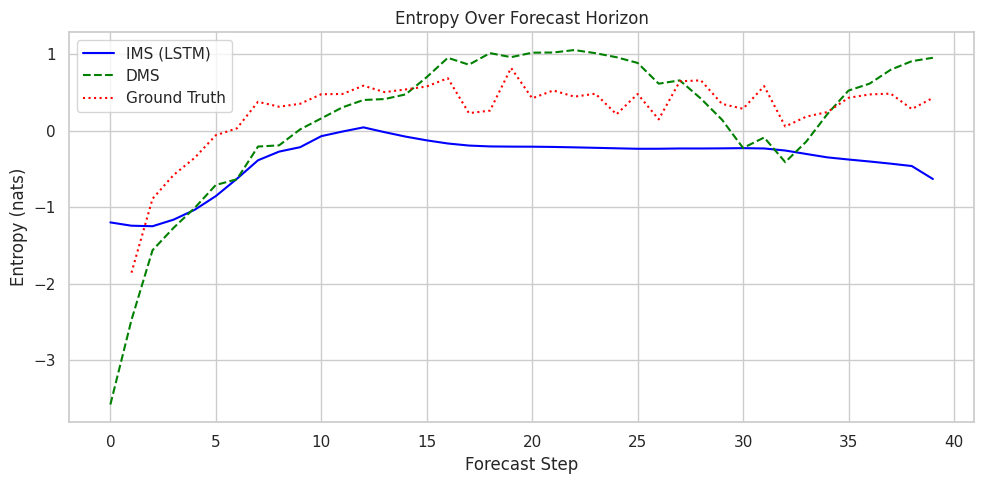

In [10]:
# Define colors and line styles for each model
plot_styles = {
    "IMS (LSTM)": {"color": "blue", "linestyle": "-"},
    "DMS": {"color": "green", "linestyle": "--"},
    "Ground Truth": {"color": "red", "linestyle": ":"}
}

# Compute ground truth entropy from the data-generating process
ground_truth_entropy = estimate_ground_truth_entropy(
    samples=multi_samples,
    world_ids=world_ids,
    prefix_len=prefix_len,
    forecast_horizon=forecast_horizon
)
entropy_plot_data = {
    "IMS (LSTM)": gaussian_entropy(sigma_ims_lstm),
    "DMS": gaussian_entropy(sigma_dms),
    "Ground Truth" : ground_truth_entropy,
}
# Plot with styling
plt.figure(figsize=(10, 5))
for label, entropy_vals in entropy_plot_data.items():
    style = plot_styles.get(label, {})
    plt.plot(entropy_vals, label=label, **style)

plt.title("Entropy Over Forecast Horizon")
plt.xlabel("Forecast Step")
plt.ylabel("Entropy (nats)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# train the ims model with teacher forcing

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import seaborn as sns

def train_ims_with_teacher_forcing(model, train_data, epochs=500, lr=1e-3, window_size=10):
    """
    Trains the IMS LSTM model using teacher forcing and Gaussian NLL loss.
    
    Args:
        model: IMSLSTM model
        train_data: torch.Tensor of shape [n_sequences, seq_length]
        epochs: number of training epochs
        lr: learning rate
        window_size: sliding window size for input sequence
    """
    train_data = train_data.float()  # Fixed: ensure data is float32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    n_sequences, seq_length = train_data.shape
    
    # Create sliding window training examples
    X_train = []
    Y_train = []
    
    for seq_idx in range(n_sequences):
        for i in range(seq_length - window_size):
            # Input: window_size consecutive values
            X_train.append(train_data[seq_idx, i:i+window_size])
            # Target: next value after the window
            Y_train.append(train_data[seq_idx, i+window_size])
    
    X_train = torch.stack(X_train)
    Y_train = torch.tensor(Y_train)
    
    for epoch in tqdm(range(epochs), total=epochs):
        model.train()
        optimizer.zero_grad()
        
        x_seq = X_train.unsqueeze(-1)  # [batch, window_size, 1]
        y_true = Y_train
        
        mu, sigma, _ = model(x_seq)  # mu, sigma: [batch]
        
        # Gaussian NLL loss
        loss = ((y_true - mu) ** 2) / (2 * sigma**2) + 0.5 * torch.log(2 * torch.pi * sigma**2)
        loss = loss.mean()
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"[IMS] Epoch {epoch} | NLL: {loss.item():.4f}")
    
    return model

def generate_samples_from_model(model, prefix_data, forecast_horizon=50, n_samples=100):
    """
    Generate samples from IMS LSTM model using autoregressive sampling.
    
    Args:
        model: IMSLSTM model
        prefix_data: numpy array of shape [prefix_len]
        forecast_horizon: number of steps to forecast
        n_samples: number of sample trajectories to generate
        
    Returns:
        samples: numpy array of shape [n_samples, prefix_len + forecast_horizon]
    """
    model.eval()
    prefix_len = len(prefix_data)
    window_size = 10  # Same as used in training
    
    # Initialize samples array
    samples = np.zeros((n_samples, prefix_len + forecast_horizon))
    samples[:, :prefix_len] = prefix_data  # Set prefix for all samples
    
    with torch.no_grad():
        for sample_idx in range(n_samples):
            # Generate future steps one by one
            for t in range(forecast_horizon):
                # Get the most recent window_size values as input
                start_idx = prefix_len + t - window_size
                if start_idx < 0:
                    # If we don't have enough history, use what we have with padding
                    pad_len = -start_idx
                    inp = np.concatenate([prefix_data[0:0+pad_len], samples[sample_idx, 0:prefix_len+t]])
                else:
                    inp = samples[sample_idx, start_idx:prefix_len+t]
                
                # Convert to tensor
                x = torch.tensor(inp.reshape(1, -1, 1), dtype=torch.float32)
                
                # Get prediction
                mu, sigma, _ = model(x)
                
                # Sample from predicted distribution
                next_val = torch.normal(mu, sigma).item()
                samples[sample_idx, prefix_len + t] = next_val
    
    return samples

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

ims_input_len = 50
X_ims, Y_ims = build_ims_dataset(multi_samples, ims_input_len)
model_ims = IMSLSTM(hidden_size=64)
trained_model = train_ims_with_teacher_forcing(
    model_ims, 
    torch.tensor(multi_samples), 
    epochs=500, 
    lr=1e-3, 
    window_size=30
)

samples = generate_samples_from_model(
    trained_model, 
    prefix_data, 
    forecast_horizon, 
    n_samples
)


  0%|▋                                                                                                                                                               | 2/500 [00:00<01:30,  5.49it/s]

[IMS] Epoch 0 | NLL: 1.2175


 20%|████████████████████████████████▏                                                                                                                             | 102/500 [00:18<01:11,  5.60it/s]

[IMS] Epoch 100 | NLL: -0.3040


 40%|███████████████████████████████████████████████████████████████▊                                                                                              | 202/500 [00:35<00:53,  5.60it/s]

[IMS] Epoch 200 | NLL: -0.4145


 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 302/500 [00:53<00:34,  5.66it/s]

[IMS] Epoch 300 | NLL: -0.4697


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 402/500 [01:11<00:17,  5.74it/s]

[IMS] Epoch 400 | NLL: -0.4880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]


NameError: name 'prefix_data' is not defined

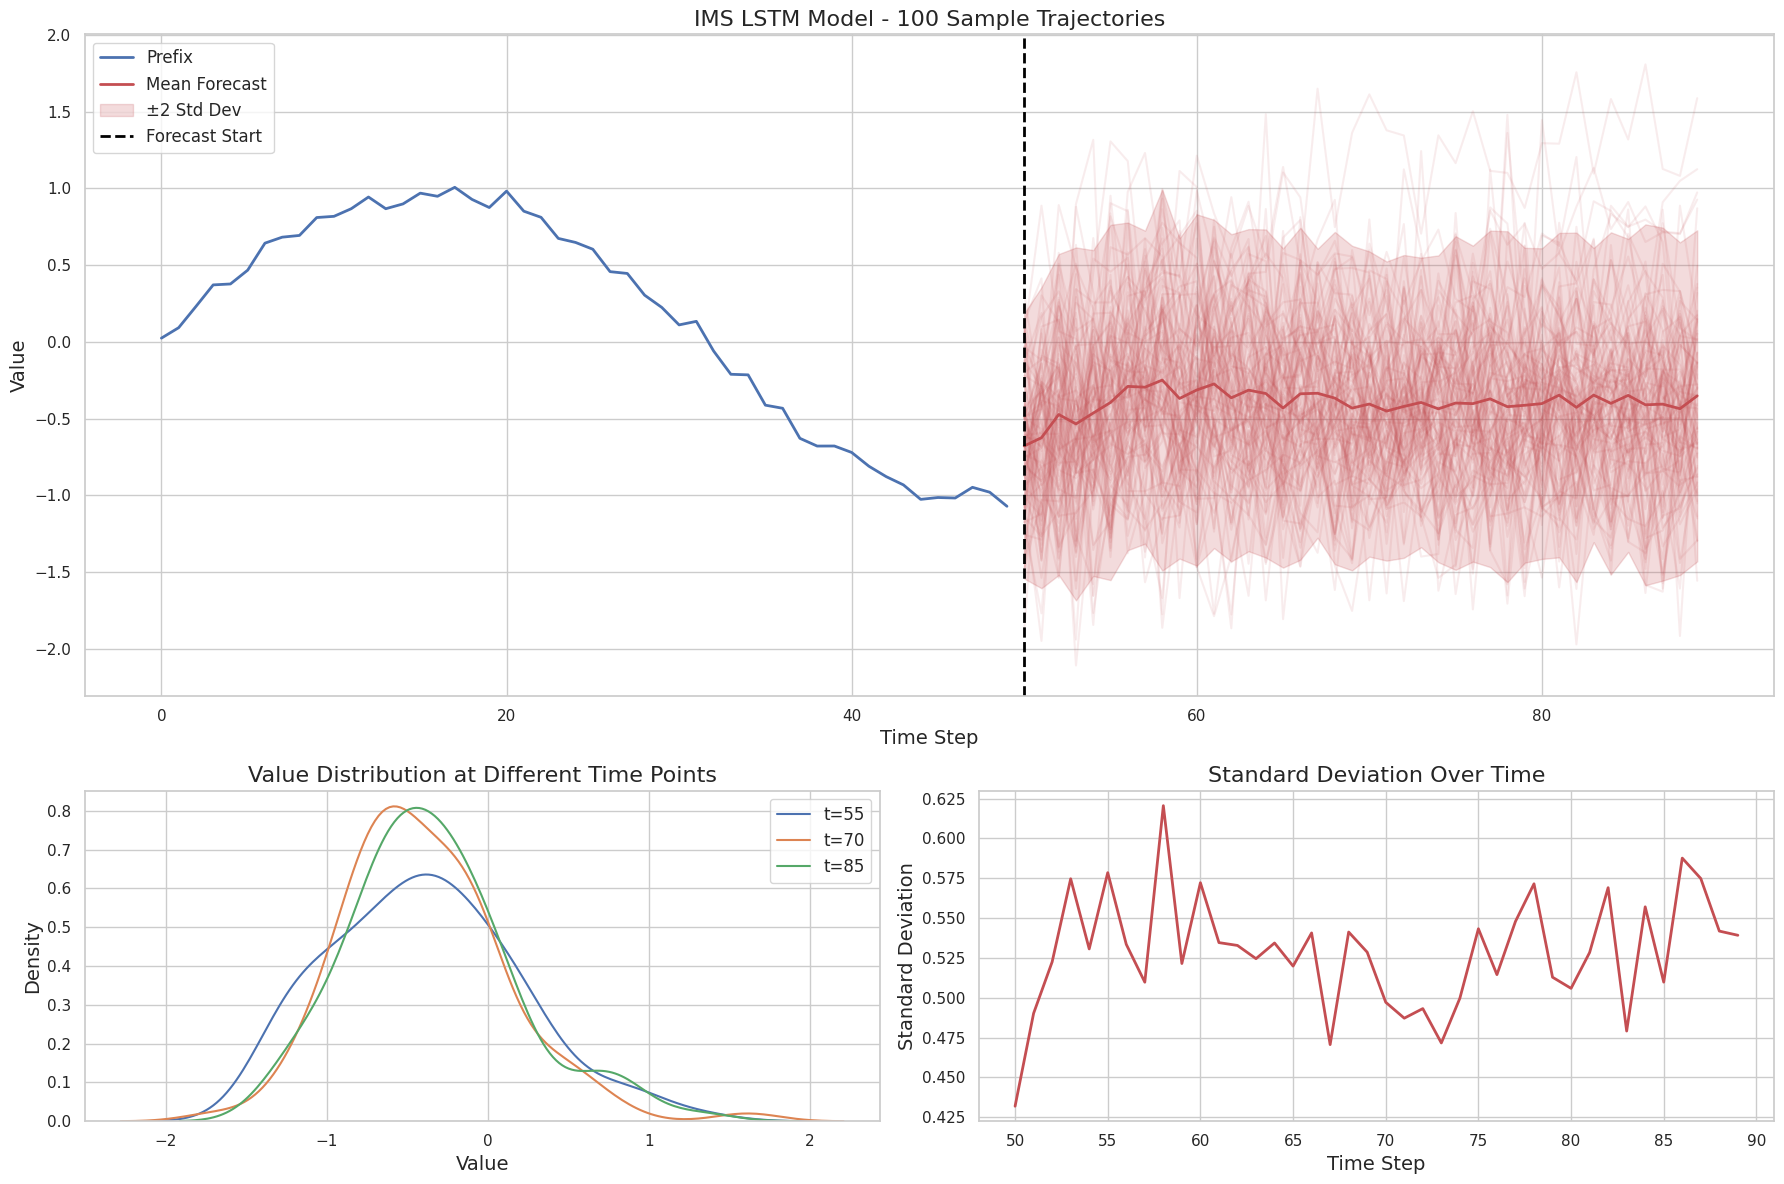

Number of samples: 100
Prefix length: 50
Forecast horizon: 40
Mean of first time step forecasts: -0.6776
Std of first time step forecasts: 0.4319
Mean of last time step forecasts: -0.3511
Std of last time step forecasts: 0.5392


In [20]:
def generate_samples_from_model(model, prefix_data, forecast_horizon=50, n_samples=100):
    """
    Generate samples from IMS LSTM model using autoregressive sampling.
    
    Args:
        model: IMSLSTM model
        prefix_data: numpy array of shape [prefix_len]
        forecast_horizon: number of steps to forecast
        n_samples: number of sample trajectories to generate
        
    Returns:
        samples: numpy array of shape [n_samples, prefix_len + forecast_horizon]
    """
    model.eval()
    prefix_len = len(prefix_data)
    window_size = 10  # Same as used in training
    
    # Initialize samples array
    samples = np.zeros((n_samples, prefix_len + forecast_horizon))
    samples[:, :prefix_len] = prefix_data  # Set prefix for all samples
    
    with torch.no_grad():
        for sample_idx in range(n_samples):
            # Generate future steps one by one
            for t in range(forecast_horizon):
                # Get the most recent window_size values as input
                start_idx = prefix_len + t - window_size
                if start_idx < 0:
                    # If we don't have enough history, use what we have with padding
                    pad_len = -start_idx
                    inp = np.concatenate([prefix_data[0:0+pad_len], samples[sample_idx, 0:prefix_len+t]])
                else:
                    inp = samples[sample_idx, start_idx:prefix_len+t]
                
                # Convert to tensor
                x = torch.tensor(inp.reshape(1, -1, 1), dtype=torch.float32)
                
                # Get prediction
                mu, sigma, _ = model(x)
                
                # Sample from predicted distribution
                next_val = torch.normal(mu, sigma).item()
                samples[sample_idx, prefix_len + t] = next_val
    
    return samples

n_samples=100
samples = generate_samples_from_model(
    trained_model, 
    multi_samples[0, :prefix_len], 
    forecast_horizon, 
    n_samples
)
# Visualize the results
plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, height_ratios=[2, 1])

# Plot all samples
ax1 = plt.subplot(gs[0, :])
# Plot prefix
ax1.plot(np.arange(prefix_len), samples[0, :prefix_len], 'b-', linewidth=2, label='Prefix')

# Plot forecasts
for i in range(n_samples):
    ax1.plot(np.arange(prefix_len, prefix_len + forecast_horizon), 
             samples[i, prefix_len:], 'r-', alpha=0.1)

# Plot mean and standard deviation of forecasts
mean_forecast = np.mean(samples[:, prefix_len:], axis=0)
std_forecast = np.std(samples[:, prefix_len:], axis=0)

ax1.plot(np.arange(prefix_len, prefix_len + forecast_horizon), 
         mean_forecast, 'r-', linewidth=2, label='Mean Forecast')
ax1.fill_between(np.arange(prefix_len, prefix_len + forecast_horizon),
                mean_forecast - 2*std_forecast,
                mean_forecast + 2*std_forecast,
                color='r', alpha=0.2, label='±2 Std Dev')

# Mark the forecasting point
ax1.axvline(prefix_len, color='black', linestyle='--', linewidth=2, label='Forecast Start')

ax1.set_title('IMS LSTM Model - 100 Sample Trajectories', fontsize=16)
ax1.set_xlabel('Time Step', fontsize=14)
ax1.set_ylabel('Value', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot distribution at specific time points
ax2 = plt.subplot(gs[1, 0])
t_points = [55, 70, 85]  # Time points to show distributions
for t in t_points:
    sns.kdeplot(samples[:, t], ax=ax2, label=f't={t}')
    
ax2.set_title('Value Distribution at Different Time Points', fontsize=16)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Density', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True)

# Plot standard deviation over time
ax3 = plt.subplot(gs[1, 1])
std_over_time = np.std(samples[:, prefix_len:], axis=0)
ax3.plot(np.arange(prefix_len, prefix_len + forecast_horizon), std_over_time, 'r-', linewidth=2)
ax3.set_title('Standard Deviation Over Time', fontsize=16)
ax3.set_xlabel('Time Step', fontsize=14)
ax3.set_ylabel('Standard Deviation', fontsize=14)
ax3.grid(True)

plt.tight_layout()
plt.show()

# Display sample statistics
print(f"Number of samples: {n_samples}")
print(f"Prefix length: {prefix_len}")
print(f"Forecast horizon: {forecast_horizon}")
print(f"Mean of first time step forecasts: {mean_forecast[0]:.4f}")
print(f"Std of first time step forecasts: {std_forecast[0]:.4f}")
print(f"Mean of last time step forecasts: {mean_forecast[-1]:.4f}")
print(f"Std of last time step forecasts: {std_forecast[-1]:.4f}")


# Unified code

=== Starting Multi-World Forecasting Experiment ===
Settings: 100 samples, 2 worlds, prefix_len=50, horizon=40

Generating multi-world time series data...

Training forecasting models...


  6%|██████▏                                                                                                 | 59/1000 [00:00<00:03, 309.78it/s]

Epoch 0: NLL = 1.1903


 26%|███████████████████████████▎                                                                           | 265/1000 [00:00<00:01, 401.12it/s]

Epoch 200: NLL = 0.0018


 47%|████████████████████████████████████████████████▋                                                      | 473/1000 [00:01<00:01, 395.98it/s]

Epoch 400: NLL = 0.0018


 68%|██████████████████████████████████████████████████████████████████████▏                                | 682/1000 [00:01<00:00, 409.12it/s]

Epoch 600: NLL = 0.0185


 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 842/1000 [00:02<00:00, 383.88it/s]

Epoch 800: NLL = 0.1158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.70it/s]


using device cuda:0
Preparing training data...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 73869.39it/s]
/home/kreffert/Probabilistic_LTSF/notebooks/experiments/multi_world_experiment.py:329: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)  # [n_samples, input_len, 1]


Training with 1000 samples in batches of 64


  1%|█                                                                                                          | 1/100 [00:02<04:04,  2.47s/it]

Epoch 0 | Avg NLL: 1.1239


 11%|███████████▋                                                                                              | 11/100 [00:17<02:17,  1.54s/it]

Epoch 10 | Avg NLL: -0.1186


 21%|██████████████████████▎                                                                                   | 21/100 [00:33<02:01,  1.54s/it]

Epoch 20 | Avg NLL: -0.1707


 31%|████████████████████████████████▊                                                                         | 31/100 [00:48<01:46,  1.54s/it]

Epoch 30 | Avg NLL: -0.1999


 41%|███████████████████████████████████████████▍                                                              | 41/100 [01:04<01:30,  1.53s/it]

Epoch 40 | Avg NLL: -0.2094


 51%|██████████████████████████████████████████████████████                                                    | 51/100 [01:19<01:15,  1.53s/it]

Epoch 50 | Avg NLL: -0.2125


 61%|████████████████████████████████████████████████████████████████▋                                         | 61/100 [01:34<01:00,  1.54s/it]

Epoch 60 | Avg NLL: -0.2194


 71%|███████████████████████████████████████████████████████████████████████████▎                              | 71/100 [01:50<00:44,  1.53s/it]

Epoch 70 | Avg NLL: -0.2147


 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 81/100 [02:05<00:29,  1.53s/it]

Epoch 80 | Avg NLL: -0.2298


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 91/100 [02:20<00:13,  1.52s/it]

Epoch 90 | Avg NLL: -0.2327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]



Evaluating models...

=== Model Evaluation Summary ===
Test sample index: 53

Negative Log-Likelihood (NLL) - lower is better:
  DMS         : 0.144
  IMS         : 4.571
  Ground Truth: -0.786

Entropy - measures uncertainty:
  DMS         : 0.014
  IMS         : -0.338
  Ground Truth: -0.557

Generating visualizations...


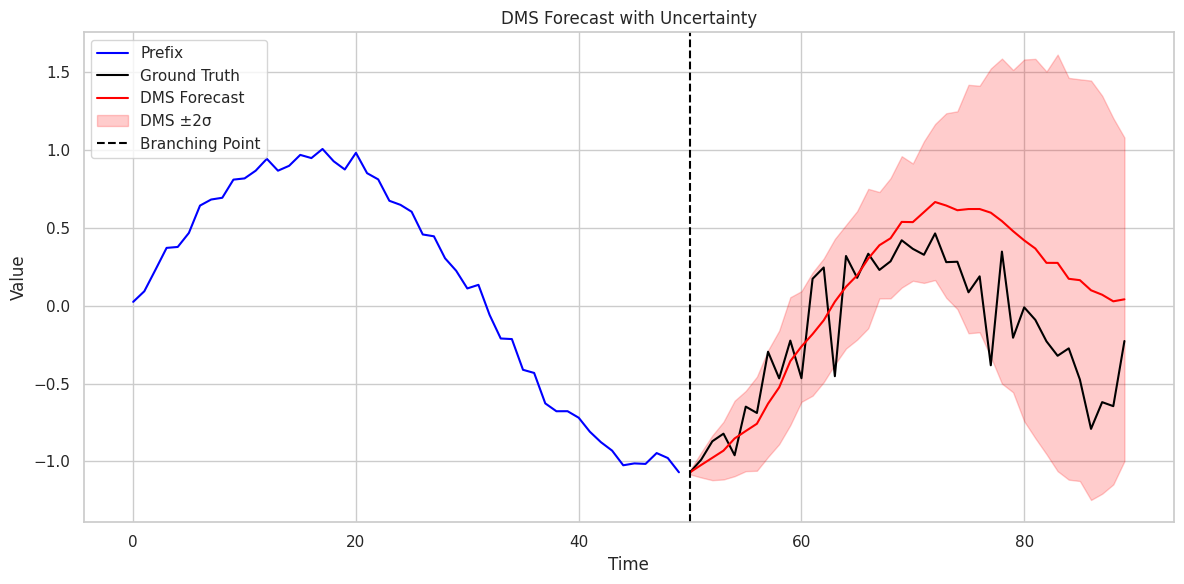

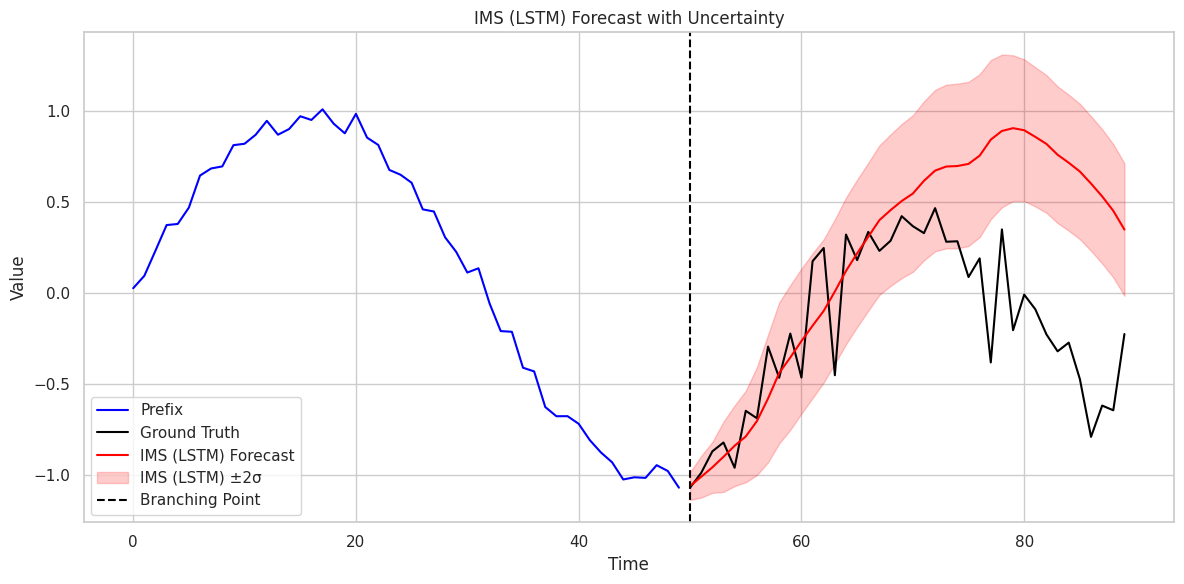

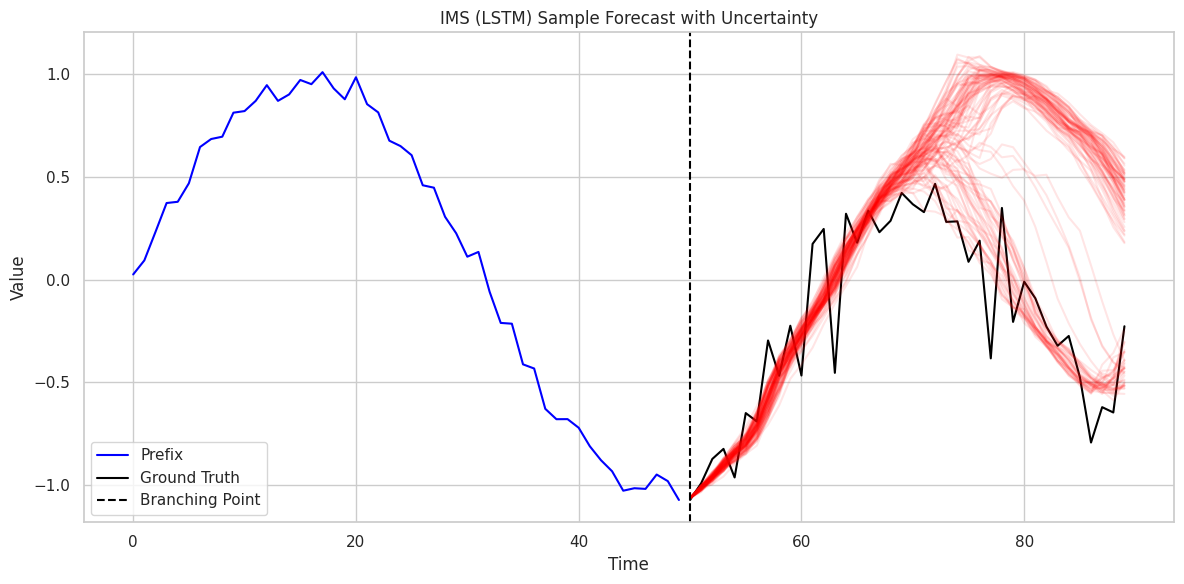

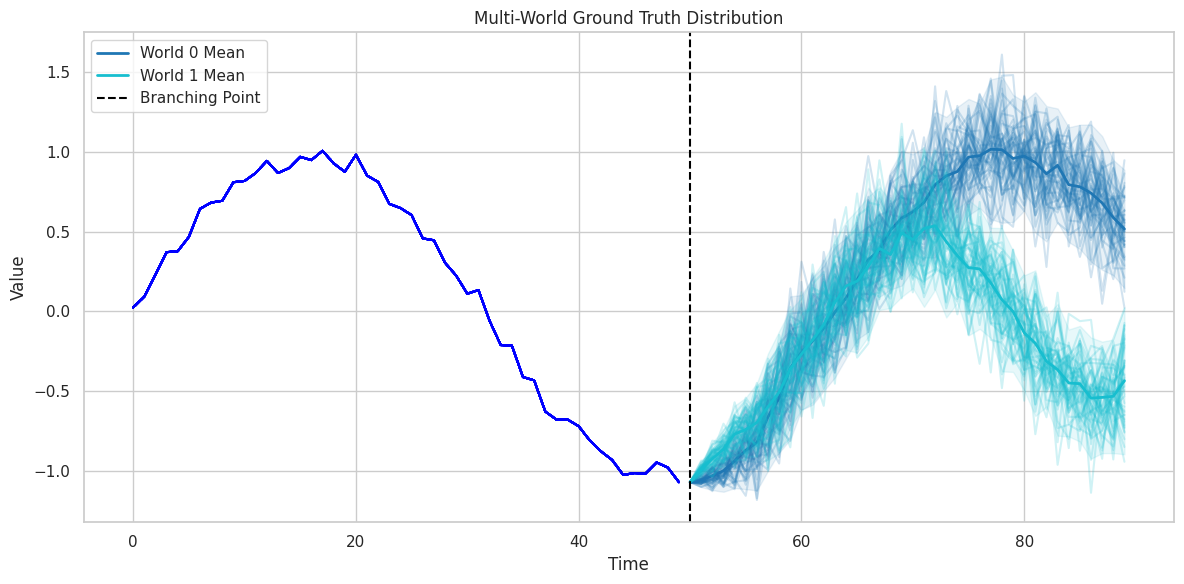

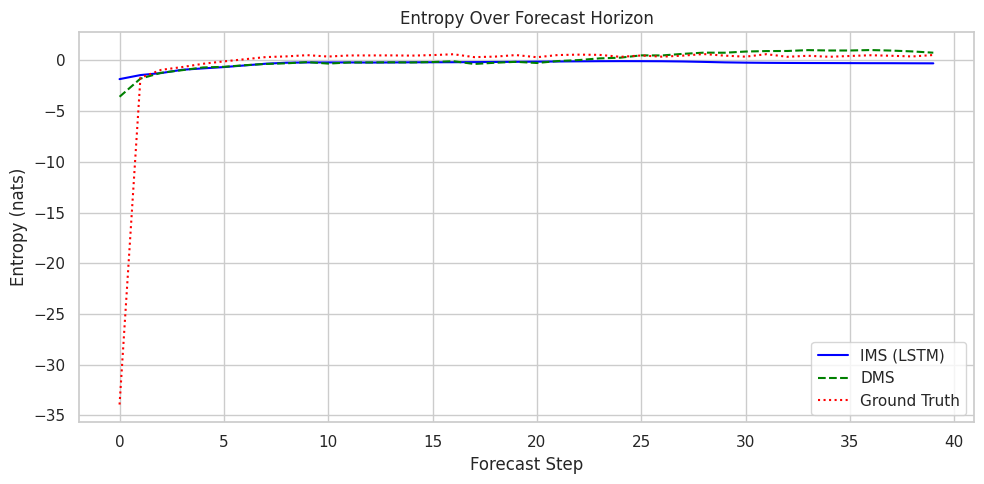

In [1]:
import os
os.chdir('/home/kreffert/Probabilistic_LTSF/notebooks/experiments')
from multi_world_experiment import MultiWorldExperiment

experiment = MultiWorldExperiment(
    seq_len=100,
    prefix_len=50, 
    forecast_horizon=40
)

results = experiment.run_experiment(
    n_samples=100,
    n_worlds=2,
    dms_epochs=1000,
    ims_epochs=100,
    num_samples_ims=100,
)


Evaluating models...

=== Model Evaluation Summary ===
Test sample index: 2

Negative Log-Likelihood (NLL) - lower is better:
  DMS         : -0.035
  IMS         : -0.283
  Ground Truth: -0.907

Entropy - measures uncertainty:
  DMS         : 0.014
  IMS         : -0.338
  Ground Truth: -0.557

Generating visualizations...


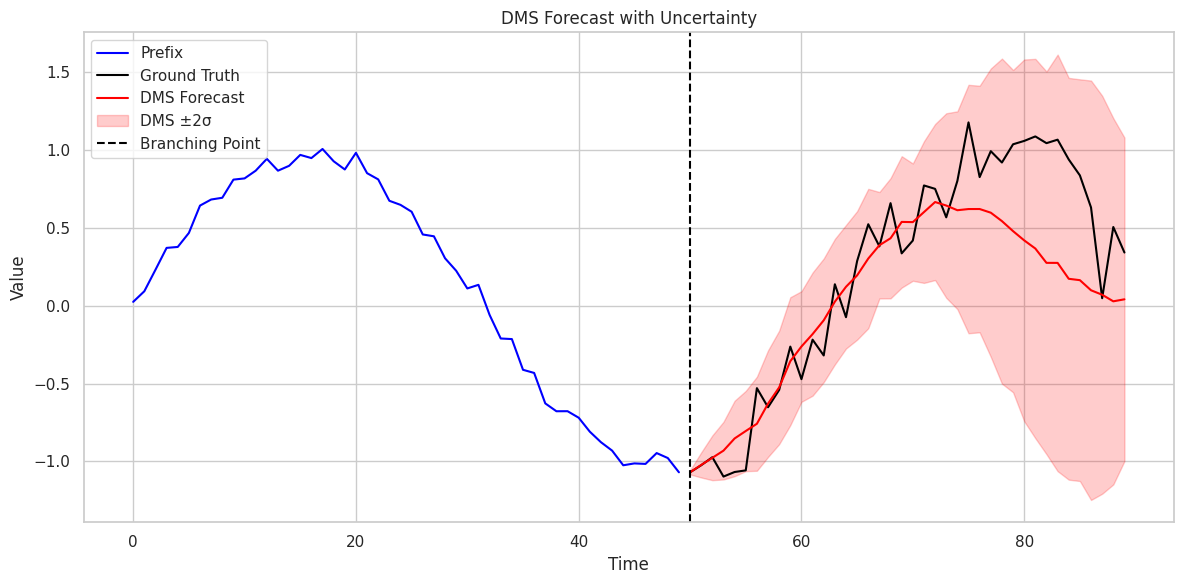

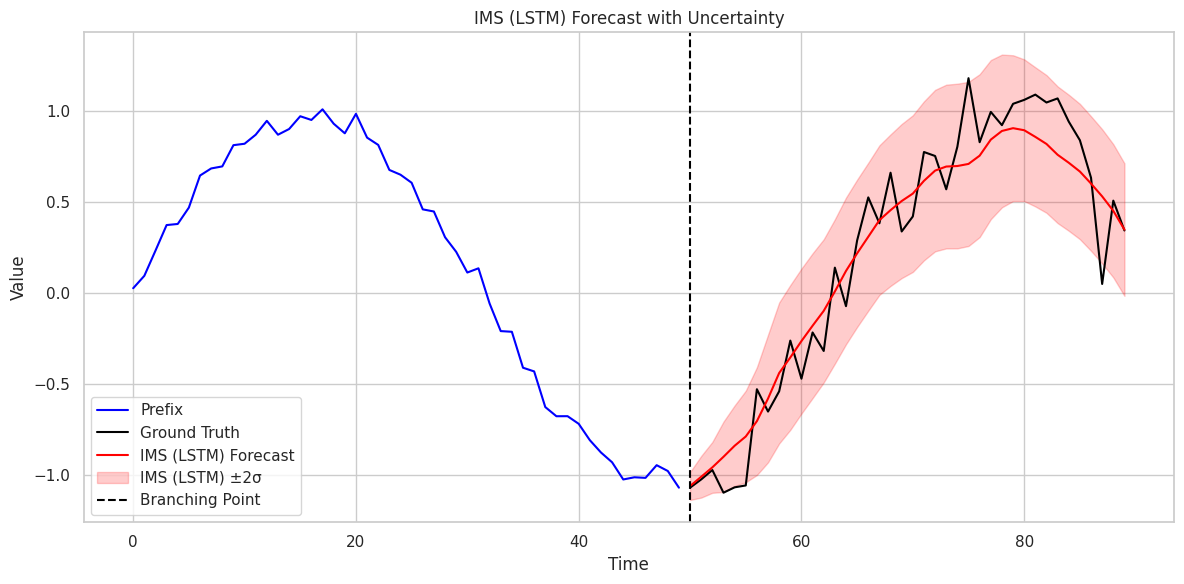

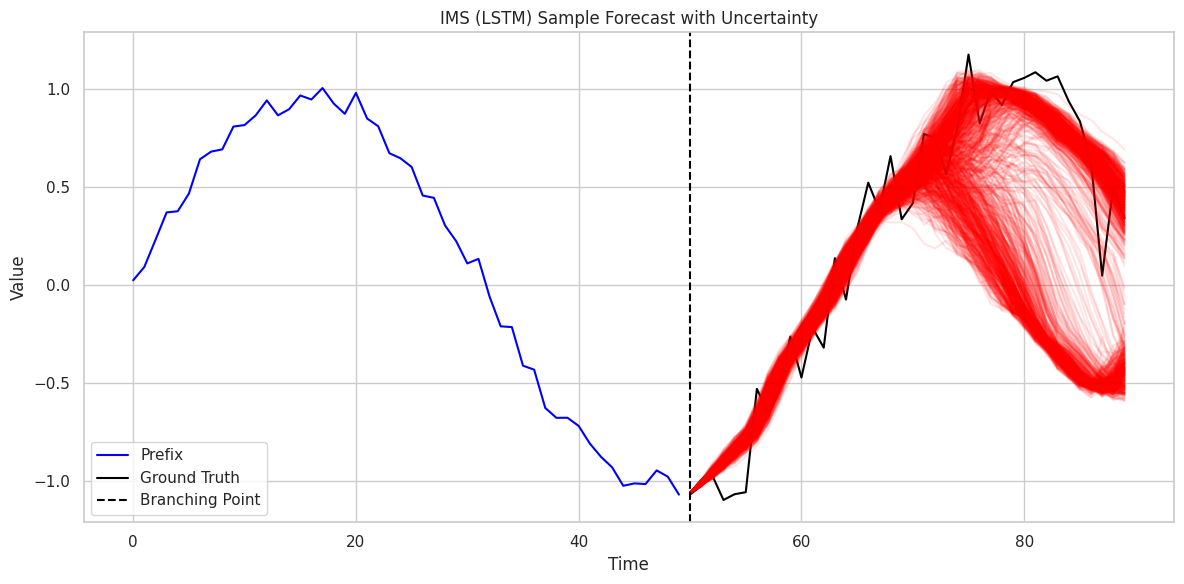

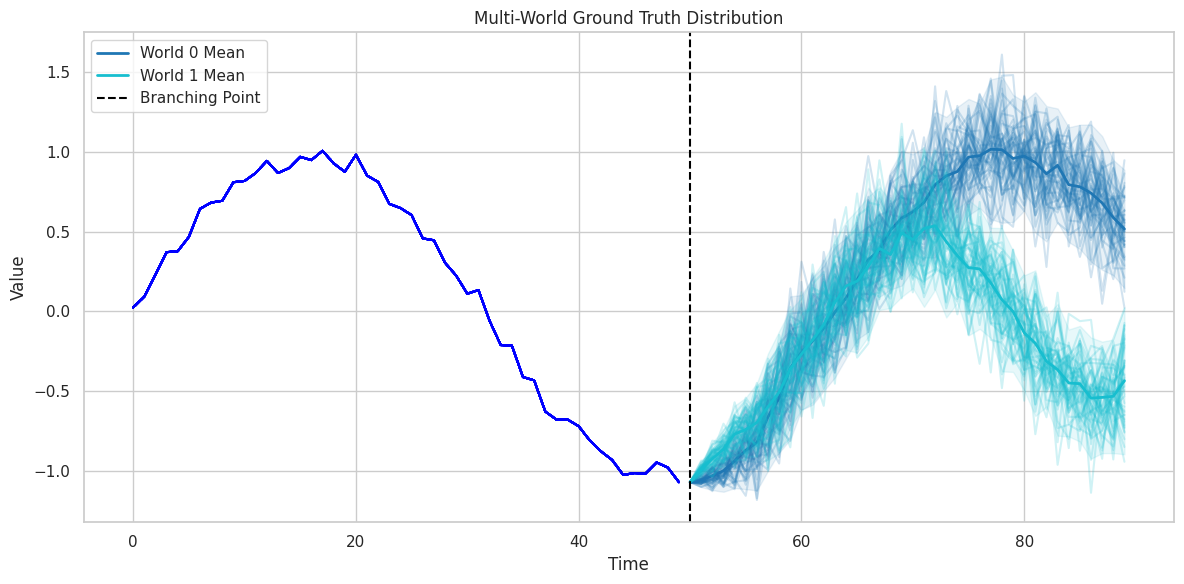

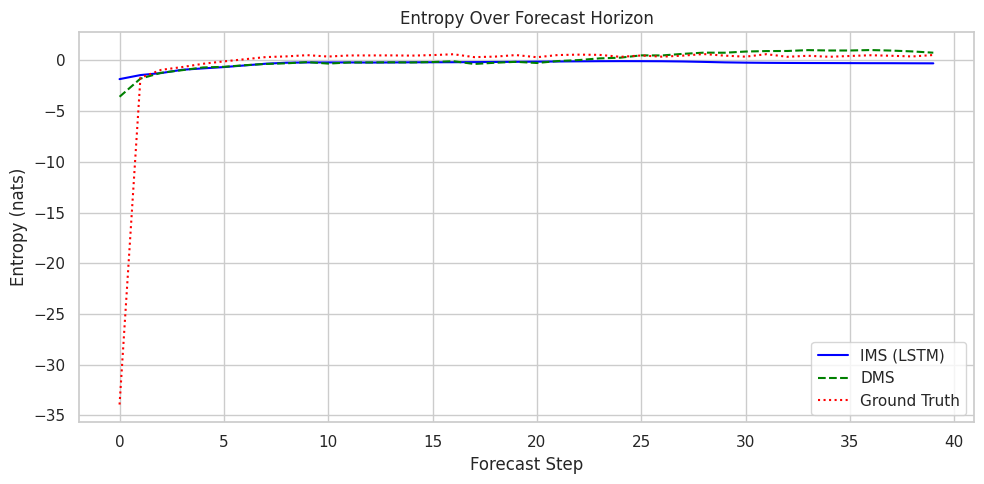

In [2]:
# Evaluate models
print("\nEvaluating models...")
results = experiment.evaluate_models(test_idx=2, num_samples_ims=1000)

# Print summary
experiment.print_evaluation_summary(results)

# Visualize results
print("\nGenerating visualizations...")
experiment.visualize_results(results)